In [1]:
import geopandas as gpd
import pandas as pd

In [2]:
leases = gpd.read_parquet("our_data/leases_with_nearest_quadrangles.parquet")
leases.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1767 entries, 0 to 124005
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   geometry            1767 non-null   geometry
 1   OBJECTID            1767 non-null   int64   
 2   landnum             1767 non-null   object  
 3   County              1767 non-null   object  
 4   parcel              1767 non-null   int64   
 5   fundtxt             1767 non-null   object  
 6   open_code           1767 non-null   int64   
 7   leased              1767 non-null   object  
 8   ke                  1767 non-null   object  
 9   lse_code            1767 non-null   int64   
 10  lse_seq             1767 non-null   int64   
 11  effdate             1766 non-null   object  
 12  expdate             1766 non-null   object  
 13  perpetual           0 non-null      object  
 14  aus                 1767 non-null   float64 
 15  rolodex_            1767 non-null

In [3]:
from shapely import wkt
wells = pd.read_parquet("our_data/wells_with_depth_trend.parquet")
wells['geometry'] = gpd.points_from_xy(
    x=wells.SITE_LONGIT_DECIMAL, 
    y=wells.SITE_LATITUDE_DECIMAL, 
    crs="EPSG:4326"
    )
wells = gpd.GeoDataFrame(data=wells, geometry='geometry')
wells.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14978 entries, 0 to 14977
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   wellid                 14978 non-null  int64   
 1   SITE_LONGIT_DECIMAL    14978 non-null  float64 
 2   SITE_LATITUDE_DECIMAL  14978 non-null  float64 
 3   depth                  14978 non-null  object  
 4   utc_seconds            14978 non-null  object  
 5   depth_20_year_trend    14978 non-null  float64 
 6   geometry               14978 non-null  geometry
dtypes: float64(3), geometry(1), int64(1), object(2)
memory usage: 819.2+ KB


In [ ]:
wells_on_lease = gpd.sjoin(left_df=leases, right_df=wells, how='left', predicate="contains")
wells_on_lease = wells_on_lease.groupby("lease_").agg({
    'depth_20_year_trend':'mean',
    })
leases_with_depth_trend = leases.merge(wells_on_lease, on="lease_", suffixes = ["", "_y"])
leases_with_depth_trend.info()
# leases = gpd.join(left_df=leases, right_df = joined_data, on="lease_")

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1767 entries, 0 to 124005
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   geometry             1767 non-null   geometry
 1   OBJECTID             1767 non-null   int64   
 2   landnum              1767 non-null   object  
 3   County               1767 non-null   object  
 4   parcel               1767 non-null   int64   
 5   fundtxt              1767 non-null   object  
 6   open_code            1767 non-null   int64   
 7   leased               1767 non-null   object  
 8   ke                   1767 non-null   object  
 9   lse_code             1767 non-null   int64   
 10  lse_seq              1767 non-null   int64   
 11  effdate              1766 non-null   object  
 12  expdate              1766 non-null   object  
 13  perpetual            0 non-null      object  
 14  aus                  1767 non-null   float64 
 15  rolodex_        

In [ ]:
wells_on_lease

,depth_20_year_trend
lease_,
0,19.406827
1,8.511935
4,10.865493
6,257.827542
7,NaN
...,...
123642,NaN
123719,NaN
123815,NaN


In [ ]:
wells_on_nearest_quadrangle

In [ ]:
leases = leases.set_geometry("nearest_quadrangle").set_crs(crs=3857)
leases = leases.set_geometry("nearest_quadrangle").to_crs(crs=4326)
# leases = leases.set_geometry("nearest_quadrangle").set_crs("EPSG:4326")
wells_on_nearest_quadrangle = gpd.sjoin(left_df=leases, right_df=wells, how='left', predicate="contains")
wells_on_nearest_quadrangle = wells_on_nearest_quadrangle.groupby("lease_").agg({
    'depth_20_year_trend':'mean',
    })
wells_on_nearest_quadrangle = wells_on_nearest_quadrangle.rename(columns ={'depth_20_year_trend':'nearby_depth_20_year_trend'})
wells_on_nearest_quadrangle.info()
leases_with_depth_trend = leases_with_depth_trend.merge(wells_on_nearest_quadrangle, on="lease_", suffixes=["", "_x"])

<class 'pandas.core.frame.DataFrame'>
Index: 1767 entries, 0 to 124005
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   nearby_depth_20_year_trend  1101 non-null   float64
dtypes: float64(1)
memory usage: 27.6 KB


In [ ]:
leases = leases.set_geometry("lease_quadrangle").set_crs(crs=3857)
leases = leases.set_geometry("lease_quadrangle").to_crs(crs=4326)
# leases = leases.drop(['index_right'], axis=1)

wells_on_lease_quadrangle = gpd.sjoin(left_df=leases, right_df=wells, how='left', predicate="contains")
wells_on_lease_quadrangle = wells_on_lease_quadrangle.groupby("lease_").agg({
    'depth_20_year_trend':'mean',
    })
wells_on_lease_quadrangle = wells_on_lease_quadrangle.rename(columns ={'depth_20_year_trend':'lease_quadrangle_depth_20_year_trend'})
leases_with_depth_trend = leases_with_depth_trend.merge(wells_on_lease_quadrangle, on="lease_", suffixes=["", "_x"])

In [ ]:
leases_with_depth_trend.info()
print(leases_with_depth_trend.columns.values)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1767 entries, 0 to 124005
Data columns (total 53 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   geometry                              1767 non-null   geometry
 1   OBJECTID                              1767 non-null   int64   
 2   landnum                               1767 non-null   object  
 3   County                                1767 non-null   object  
 4   parcel                                1767 non-null   int64   
 5   fundtxt                               1767 non-null   object  
 6   open_code                             1767 non-null   int64   
 7   leased                                1767 non-null   object  
 8   ke                                    1767 non-null   object  
 9   lse_code                              1767 non-null   int64   
 10  lse_seq                               1767 non-null   int64   
 11 

In [ ]:
print(leases_with_depth_trend["depth_20_year_trend"].mean())
print(leases_with_depth_trend["lease_quadrangle_depth_20_year_trend"].mean())
print(leases_with_depth_trend["nearby_depth_20_year_trend"].mean())

28.717290110539743
-58.24896613236815
22.302963468363508


In [ ]:
leases_with_depth_trend.to_parquet("our_data/processed_data.parquet")

KeyboardInterrupt: 

In [ ]:
leases_with_depth_trend.head()

KeyboardInterrupt: 

In [ ]:
leases_with_depth_trend[[
    "depth_20_year_trend", 
    "lease_quadrangle_depth_20_year_trend", 
    "nearby_depth_20_year_trend"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1767 entries, 0 to 124005
Data columns (total 3 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   depth_20_year_trend                   460 non-null    float64
 1   lease_quadrangle_depth_20_year_trend  1523 non-null   float64
 2   nearby_depth_20_year_trend            1101 non-null   float64
dtypes: float64(3)
memory usage: 55.2 KB


In [ ]:
# the geometries you have are the nearest_quardrangle, lease_quadrangle, and geometry (the lease)
# random change

In [ ]:
depth20=leases_with_depth_trend["depth_20_year_trend"].dropna()

In [ ]:
print(depth20.mean())


28.717290110539746


In [ ]:
lease20=leases_with_depth_trend["lease_quadrangle_depth_20_year_trend"].dropna()
near20=leases_with_depth_trend["nearby_depth_20_year_trend"].dropna()

In [ ]:
lease20m=(lease20.mean())
near20m=(near20.mean())
depth20m=(depth20.mean())

lease_
0          19.406827
1           8.511935
4          10.865493
6         257.827542
15         96.254222
             ...    
120119     -1.540091
120357     68.358357
121813     -8.362685
122697     -8.620196
123013      1.583926
Name: depth_20_year_trend, Length: 460, dtype: float64


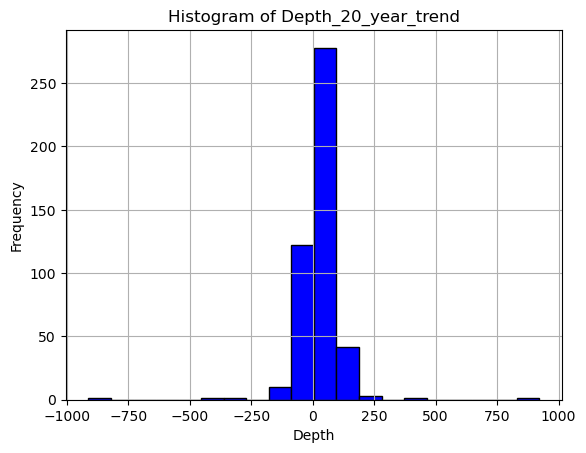

In [ ]:
print(depth20)
import matplotlib.pyplot as plt

# Given data
data = [depth20]

# Plot histogram
plt.hist(data, bins=20, color='blue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.title('Histogram of Depth_20_year_trend')
plt.grid(True)
plt.show()


In [ ]:
wells_on_nearest_quadrangle

,nearby_depth_20_year_trend
lease_,
0,NaN
1,16.450487
4,31.082192
6,NaN
7,21.169569
...,...
123642,103.644245
123719,NaN
123815,12.688918


In [ ]:
wells_on_lease_quadrangle

,lease_quadrangle_depth_20_year_trend
lease_,
0,NaN
1,11.843229
4,62.162484
6,4.999942
7,10.574822
...,...
123642,71.723256
123719,66.868056
123815,12.688918


In [ ]:
import plotly.express as px
leases_with_depth_trend["depth_20_year_trend"] = px.data.tips()
fig = px.histogram(leases_with_depth_trend, x="total_bill")
fig.show()

ValueError: Columns must be same length as key